## Challenge ITMidia

**Objetivo**

*   Criar um projeto em visão computacional capz de capturar o movimentos dos olhos e gerar amostragem dos portais da ITMidia, com o intuito de gerar indicadores dos campos mais vistos pelos os usuários consequentemente evidenciar o que mais gera engajamento. 


## Código em Python

O código para a execução do objetivo se encontra abaixo.
Obs: Falta ajuste em parametros para melhor correlação da visão para a tela.

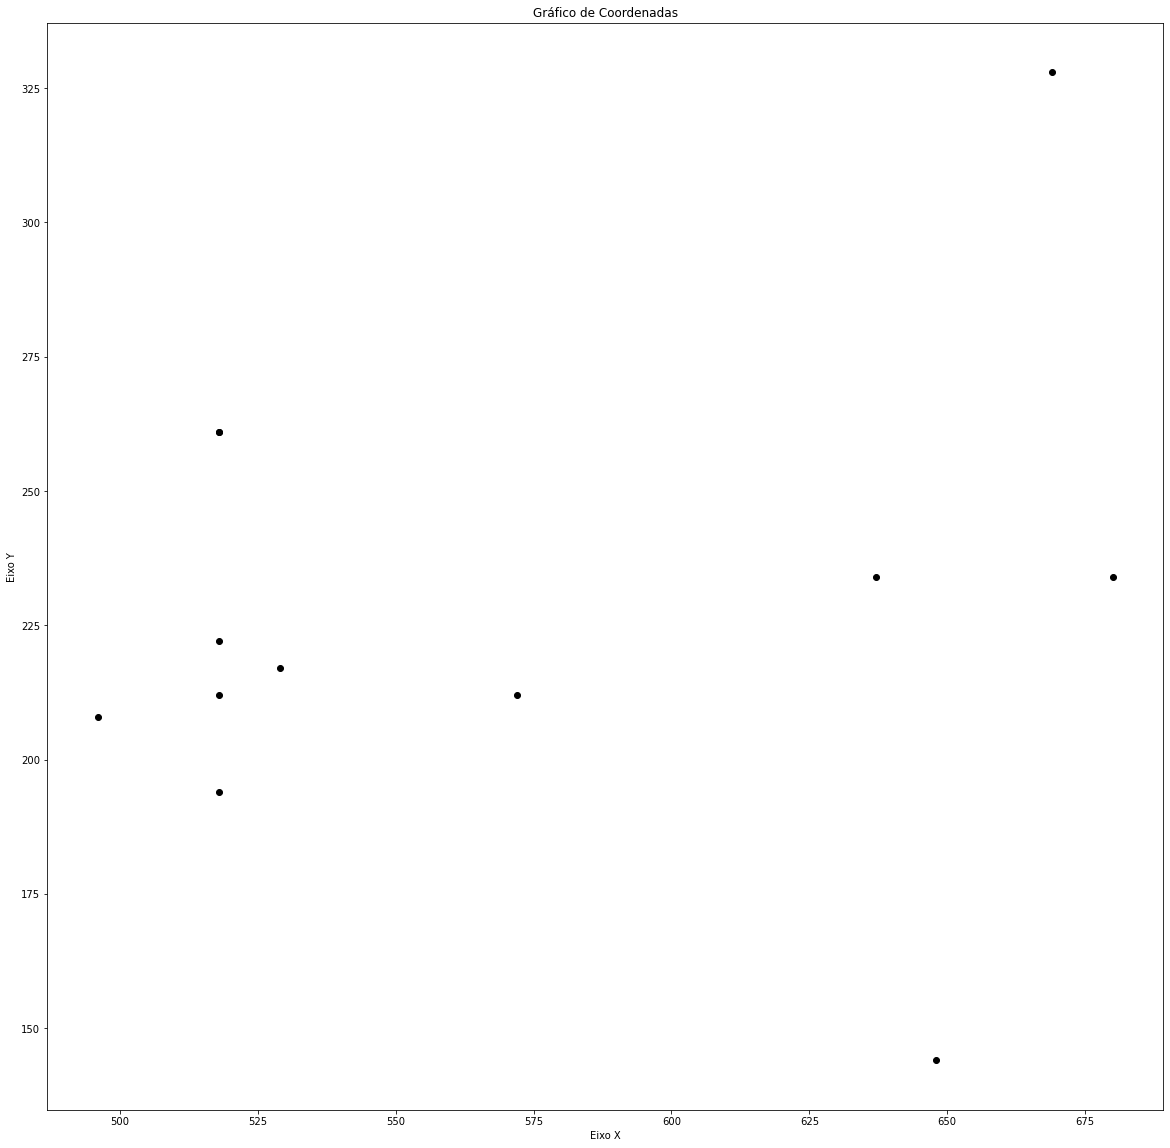

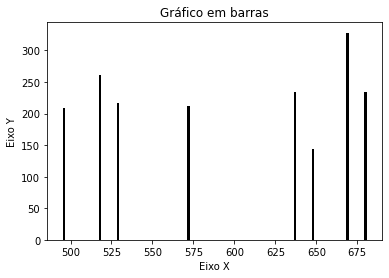

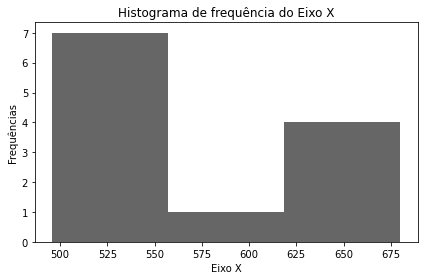

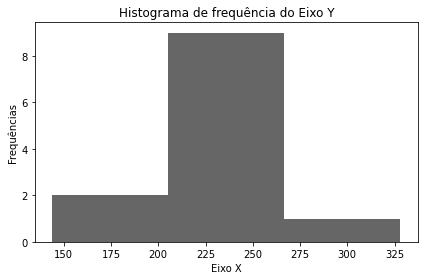

In [1]:
#importação das bibliotecas utilizadas
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
from threading import Thread
from gaze_tracking import GazeTracking
import keyboard
import numpy as np
import imutils
import time
import dlib
import cv2
import matplotlib.pyplot as plt

#Mapeamento das pupilas
gaze = GazeTracking()
# Detector de faces DLIB
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# pegar os índices do previsor, para olhos esquerdo e direito
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# inicializar vídeo
vs = cv2.VideoCapture(1)

#Listas para captação das cordenadas do olhar, no caso de um olho só 
listaX =[]
listaY =[]



# loop sobre os frames do vídeo
while True:
    ret, frame = vs.read()
    #Detectando a pupila e desenhando um circulo verde que irá fazer também o mapeamento dela
    gaze.refresh(frame)
    frame = gaze.annotated_frame()
    
    cropleftEye = cv2.imread("fundo.jpg")
    croprightEye = cv2.imread("fundo.jpg")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detectar faces (grayscale)
    rects = detector(gray, 0)

    # loop nas detecções de faces
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # extrair coordenadas dos olhos e calcular a proporção de abertura
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
     

        # convex hull cria um contorno com base nos pontos
        '''
        leftEyeHull = cv2.convexHull(leftEye)
        ightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        print(leftEye)
        '''
        
        #Determinando as constante para a detecção dos tons de verde
        greenLower = np.array([29, 86, 6])
        greenUpper = np.array([64, 255, 255])
        (x, y, w, h) = cv2.boundingRect(leftEye)
        (x2, y2, w2, h2) = cv2.boundingRect(rightEye)
        #Desenho do retangulo dos olhos
        cv2.rectangle(frame, (x,y), (x+w,y+h), (255,255,0), 1)
        cv2.rectangle(frame, (x2,y2), (x2+w2,y2+h2), (255,255,0), 1)
        #Recortando o olho esquerdo em tempo real
        cropleftEye = frame[y:y+h, x:x+w]
        cropleftEye = imutils.resize(cropleftEye, width=100)
        
        #Criando uma máscara para captação de elementos verdes no frame do olho esquerdo, no caso será o circulo verde da pupila
        hsvLeft = cv2.cvtColor(cropleftEye, cv2.COLOR_BGR2HSV)
        maskLeft = cv2.inRange(hsvLeft, greenLower, greenUpper)
        #resultLeft = cv2.bitwise_and(cropleftEye, cropleftEye, maskLeft=maskLeft)
        
        #Detectando o contorno do circulo verde da pupila
        cntsLeft = cv2.findContours(maskLeft.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cntsLeft = imutils.grab_contours(cntsLeft)
        centerLeft = None
        #Capturando o circulo verde da pupila
        if len(cntsLeft) > 0:

            c = max(cntsLeft, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            centerLeft = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            xCircL = centerLeft[0]
            xCircL = np.uint16(np.around(xCircL))
            yCircL = centerLeft[1]
            yCircL = np.uint16(np.around(yCircL))
            centerxyCircL = (xCircL,yCircL)
            
            if radius > 10: 
                cv2.circle(cropleftEye, (int(x), int(y)), int(radius),
                    (0, 255, 255), 2)
                cv2.circle(cropleftEye, centerLeft, 5, (0, 0, 255), -1)
        #print(centerLeft)      
        
        
        #Recortando o olho esquerdo em tempo real
        croprightEye = frame[y2:y2+h2, x2:x2+w2]
        croprightEye = imutils.resize(croprightEye, width=100)
        #Criando uma máscara para captação de elementos verdes no frame do olho esquerdo, no caso será o circulo verde da pupila
        hsvRight = cv2.cvtColor(croprightEye, cv2.COLOR_BGR2HSV)
        maskRight = cv2.inRange(hsvRight, greenLower, greenUpper)
        #resultRight = cv2.bitwise_and(croprightEye, croprightEye, maskRight=maskRight)
        
        #Detectando o contorno do circulo verde da pupila
        cntsRight = cv2.findContours(maskRight.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cntsRight = imutils.grab_contours(cntsRight)
        centerRight = None
        #Capturando o circulo verde da pupila
        if len(cntsRight) > 0:

            c = max(cntsRight, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            centerRight = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            xCircR = centerRight[0]
            xCircR = np.uint16(np.around(xCircR))
            yCircR = centerRight[1]
            yCircR = np.uint16(np.around(yCircR))
            centerxyCircR = (xCircR,yCircR)
            
            if radius > 10: 
                cv2.circle(croprightEye, (int(x), int(y)), int(radius),
                    (0, 255, 255), 2)
                cv2.circle(croprightEye, centerRight, 5, (0, 0, 255), -1)
        #Esta (largura, altura)        
        #print("Cordenada do centro da pupila direita = ", centerRight)
        #print("Cordenada do centro da pupila direits 2 = ", centerxyCircR)
        
        #transformando o recorte dos olhos em escala de cinza
        grayLeft = cv2.cvtColor(cropleftEye , cv2.COLOR_BGR2GRAY)
        grayRight = cv2.cvtColor(croprightEye , cv2.COLOR_BGR2GRAY)
        
        #capturando os eixos x e y dos recortes do olho esquerdo, NO CASO ABAIXO 0 é y E 1 É x
        xRecL = grayLeft.shape[0]
        yRecL = grayLeft.shape[1]
        #Caputando os eixos x e y do centro do retangulo do olho esquerdo
        if xRecL is not None or yRecL is not None:
            xRecL = np.uint16(np.around(xRecL))
            centerxRecL = xRecL/2
            centerxRecL = np.uint16(centerxRecL)
            yRecL = np.uint16(np.around(yRecL))
            centeryRecL = yRecL/2
            centeryRecL = np.uint16(centeryRecL)
            #centerxyRecL = (centeryRecL, centerxRecL)
            
            
        #capturando os eixos x e y dos recortes do olho direito, NO CASO ABAIXO 0 é y E 1 É x    
        xRecR = grayRight.shape[0]
        yRecR = grayRight.shape[1]
        #Caputando os eixos x e y do centro do retangulo do olho direito
        if xRecR is not None or yRecR is not None:
            xRecR = np.uint16(np.around(xRecR))
            centerxRecR = xRecR/2
            centerxRecR = np.uint16(centerxRecR)
            yRecR = np.uint16(np.around(yRecR))
            centeryRecR = yRecR/2
            centeryRecR = np.uint16(centeryRecR)
            centerxyRecR = (centeryRecR,centerxRecR)
        #Esta (largura, altura) 
        #print("Cordenada do centro do olho direito = ",centerxyRecR)
        
      
        #Estrutura de condição para captação dos eixos da pupila e inserção de circulos na imagem que aparecerá na tela
        #Necessário apertar a tecla P para rodar
        if keyboard.is_pressed('p'):

            #Calculando a porcentagem do olho esquerdo
            if xCircL is not None or yCircL is not None or xRecL is not None or yRecL is not None:
                porxCircL = (xCircL*100)/yRecL
                poryCircL = (yCircL*100)/xRecL

            #Calculando a porcentagem do olho direito
            if xCircR is not None or yCircR is not None or xRecR is not None or yRecR is not None:
                porxCircR = (xCircR*100)/yRecR
                poryCircR = (yCircR*100)/xRecR

            #Pegando a proporção da imagem, para testar com outra basta troca o caminho dela abaixo
            img_itforum = cv2.imread('itforum.jpg', cv2.IMREAD_COLOR)
            copyimg = img_itforum.copy()
            img_itforum_gray = cv2.cvtColor(img_itforum , cv2.COLOR_BGR2GRAY)
            yimg = img_itforum_gray.shape[0]
            ximg = img_itforum_gray.shape[1]

            if yimg is not None or ximg is not None:
                yimg = np.uint16(np.around(yimg))
                ximg = np.uint16(np.around(ximg))
                #Correlacionando as coordenadas do olho esquerdo e desenhando pontos na imagem
                xpontoL = (ximg*porxCircL)/100
                ypontoL = (yimg*poryCircL)/100
                xpontoL = np.uint16(xpontoL)
                ypontoL = np.uint16(ypontoL)
                #Correlacionando as coordenadas do olho direito e desenhando pontos na imagem
                xpontoR = (ximg*porxCircR)/100
                ypontoR = (yimg*poryCircR)/100
                xpontoR = np.uint16(xpontoR)
                ypontoR = np.uint16(ypontoR)
                Vision = [xpontoR, ypontoR]
                
                #Desenhando
                #cv2.circle(copyimg, (xpontoL,ypontoL), 20, (0,140,255), -1)
                cv2.circle(copyimg, (xpontoR, ypontoR), 20, (0,165,255), -1)
                alpha = 0.4
                img_itforum = cv2.addWeighted(copyimg, alpha, img_itforum, 1 - alpha, 0)
                #Executando a imagem e salvando ela para gerar um loop das marcações feitas pelos olhos
                cv2.imshow("Desenho", img_itforum)
                cv2.imwrite("itforum.jpg", img_itforum)
                
                #Listas para captação das coordenadas da visão, adicionando cada uma conforme o loop vai rodando
                listaX.append(xpontoR)
                listaY.append(ypontoR)
               
                
          
        
        
        
        
        
        
        #Utilizando a técnica de HoughCircles para a detecção das pupilas
        '''
        grayLeft = cv2.cvtColor(cropleftEye , cv2.COLOR_BGR2GRAY)
        grayLeft = cv2.medianBlur(grayLeft,5)
        grayRight = cv2.cvtColor(croprightEye , cv2.COLOR_BGR2GRAY)
        grayRight = cv2.medianBlur(grayRight,5)
     
        circlesLeft = cv2.HoughCircles(grayLeft, cv2.HOUGH_GRADIENT, 0.1, 17,param1=10, param2=13, minRadius=7, maxRadius=13)
        circlesRight = cv2.HoughCircles(grayRight, cv2.HOUGH_GRADIENT, 0.1, 17,param1=10, param2=13, minRadius=7, maxRadius=13)
       
    
        if circlesLeft is not None:
            # convert the (x, y) coordinates and radius of the circles to integers
            circlesLeft = np.round(circlesLeft[0, :]).astype("int")

            # loop over the (x, y) coordinates and radius of the circles
            for (x3, y3, r3) in circlesLeft:
                # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
                cv2.circle(cropleftEye, (x3, y3), r3, (0, 255, 0), 1)
                cv2.rectangle(cropleftEye, (x3 - 1, y3 - 1), (x3 + 1, y3 + 1), (0, 128, 255), -1)
        
        
        # ensure at least some circles were found
        if circlesRight is not None:
            # convert the (x, y) coordinates and radius of the circles to integers
            circlesRight = np.round(circlesRight[0, :]).astype("int")

            # loop over the (x, y) coordinates and radius of the circles
            for (x4, y4, r4) in circlesRight:
                # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
                cv2.circle(croprightEye, (x4, y4), r4, (0, 255, 0), 1)
                cv2.rectangle(croprightEye, (x4 - 1, y4 - 1), (x4 + 1, y4 + 1), (0, 128, 255), -1)
        '''   
        
        

    #Execução dos frames
    cv2.imshow("Olho Esquerdo", cropleftEye)
    cv2.imshow("Olho Direito", croprightEye)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # tecla para sair do script "q"
    if key == ord("q"):
        break

#Fechamento das janelas após ter apertado a tecla q
cv2.destroyAllWindows()
vs.release()


fig = plt.figure(figsize=(20,20))
plt.title('Gráfico de Coordenadas')
plt.scatter(listaX,listaY, c='k')
plt.xlabel("Eixo X")
plt.ylabel("Eixo Y")
plt.savefig('GraficoDeCoordenadas.png', format='png')
plt.show()

plt.title('Gráfico em barras')
width_n = 1.75   # Largura das Colunas 
bar_color = 'k'  # Côr da barra = Preto
plt.bar(listaX, listaY, width=width_n, color=bar_color)
plt.xlabel("Eixo X")
plt.ylabel("Eixo Y")
plt.savefig('GraficoDeBarras.png', format='png')
plt.show()

plt.title("Histograma de frequência do Eixo X")
#Tamanho da amostra
tamanho = len(listaX)
# quantidade de Classes (bins)
cl = int(round(tamanho**(1/2),0))
plt.xlabel("Eixo X")
plt.ylabel("Frequências")
# Range é uma tupla indicando o intervalo das coordenadas. alpha corresponde a saturação da cor
plt.hist(listaX, bins = cl, range = ( min(listaX), max(listaX)), alpha = 0.6, color='k')
plt.tight_layout()
plt.savefig('HistogramaEixoX.png', format='png')
plt.show()

plt.title("Histograma de frequência do Eixo Y")
#Tamanho da amostra
tamanho = len(listaY)
# quantidade de Classes (bins)
cl = int(round(tamanho**(1/2),0))
plt.xlabel("Eixo X")
plt.ylabel("Frequências")
# Range é uma tupla indicando o intervalo das coordenadas. alpha corresponde a saturação da cor
plt.hist(listaY, bins = cl, range = ( min(listaY), max(listaY)), alpha = 0.6, color='k')
plt.tight_layout()
plt.savefig('HistogramaEixoY.png', format='png')
plt.show()